## Downloading libraries

In [2]:
# Install necessary package
!pip install lifelines

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from google.colab import files

# Upload the file
uploaded = files.upload()

# Replace the filename with your uploaded file name
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# Rename columns for easier handling
df = df.rename(columns={
    "KRT (age at onset, yrs)": "KRT_age",
    "Portal HTN during disease course (age, yrs)": "Portal_HTN_age",
    "Substan- tial hepatic compli- cation during disease course (age, yrs)": "Hepatic_complication_age",
    "Last follow- up (age, yrs), Death": "Last_followup_age",
    "Final_Class": "Functional_Class"
})

# Clean data
cols_to_clean = ["KRT_age", "Portal_HTN_age", "Hepatic_complication_age", "Last_followup_age"]
df[cols_to_clean] = df[cols_to_clean].replace(['-', '#ERROR!'], np.nan).apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=["Functional_Class", "Last_followup_age"])

# Set up Kaplan–Meier fitter and plot info
kmf = KaplanMeierFitter()
events = {
    "KRT_age": "Time without KRT",
    "Portal_HTN_age": "Time without portal hypertension",
    "Hepatic_complication_age": "Time without substantial hepatic complication"
}
color_map = {
    "AA1-708": "blue",
    "AA709-1837": "red",
    "AA1838-2624": "green",
    "AA2625-4074": "orange"
}

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 6.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=648e43894aadd4349ff38982b801c664261348358c880adc9500e39f041c8fbd
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


Saving Burgmaier_Genotype_Phenotype_Replication - Data for Visualization (3).csv to Burgmaier_Genotype_Phenotype_Replication - Data for Visualization (3).csv


## Replication of Burgmaier et al., (2021).

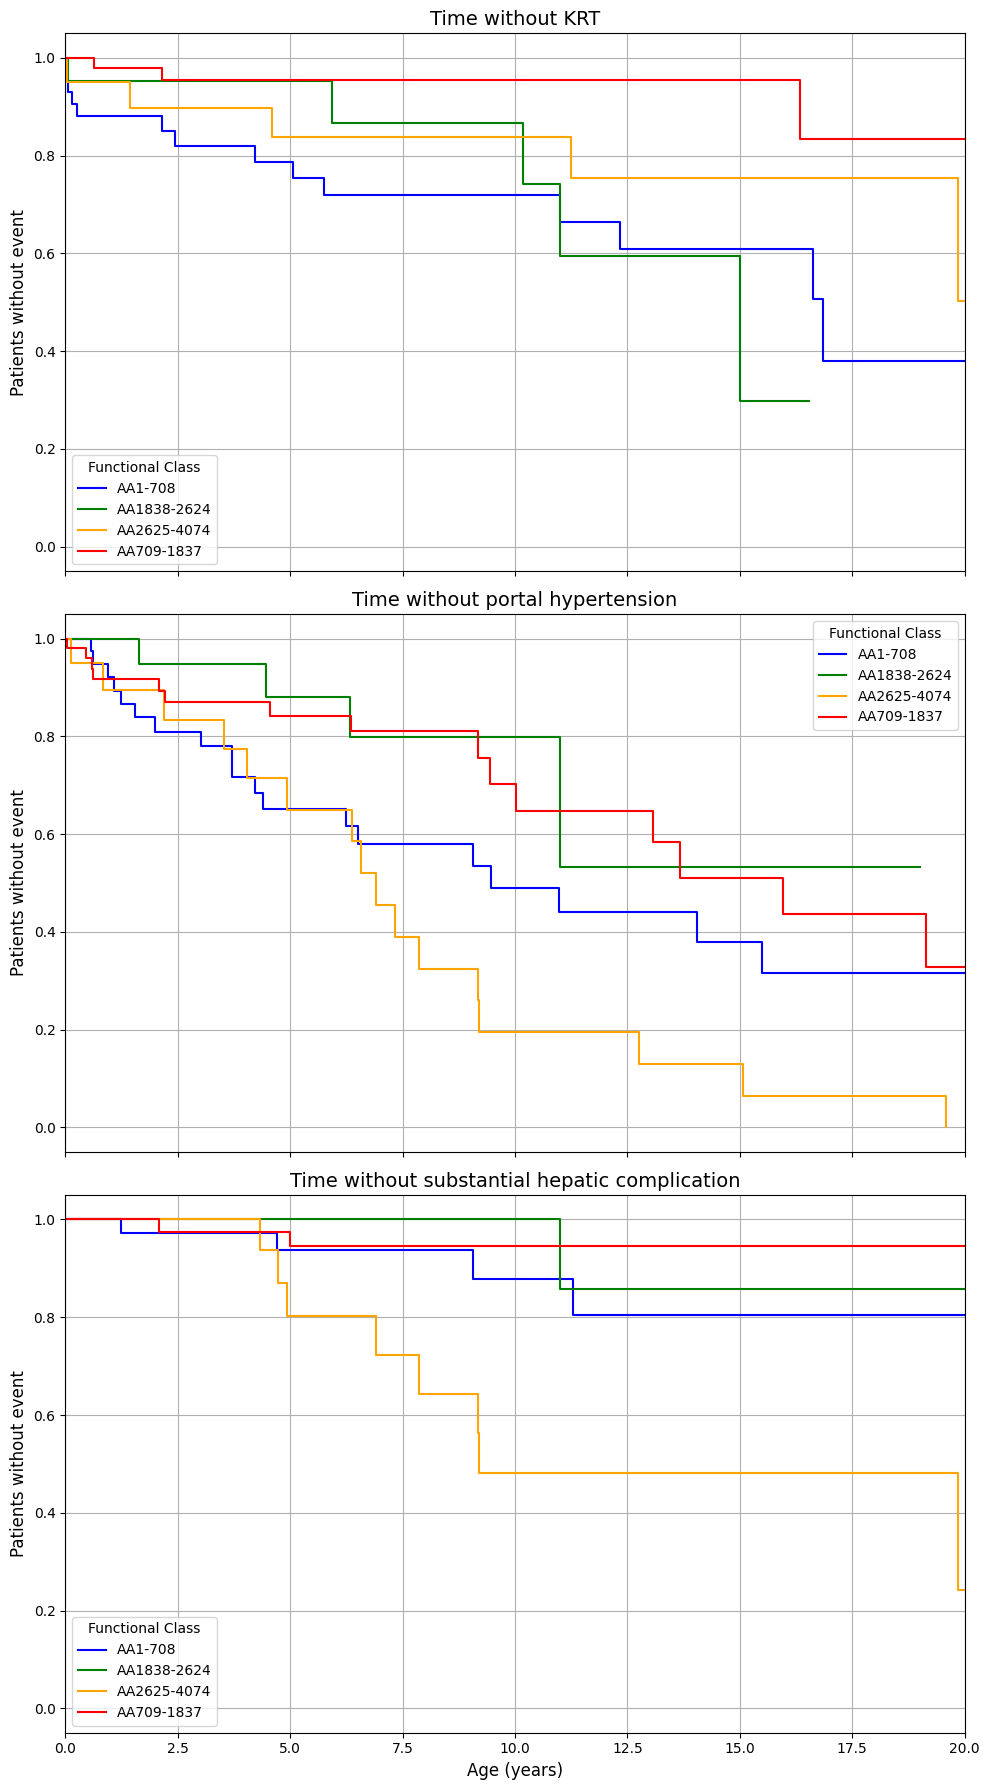

In [3]:
# Plot
fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

for ax, (event_col, title) in zip(axes, events.items()):
    for group in df["Functional_Class"].unique():
        group_df = df[df["Functional_Class"] == group].copy()
        if group_df.empty:
            continue

        # Define time-to-event and censoring
        group_df["time"] = group_df[event_col].fillna(group_df["Last_followup_age"])
        group_df["event"] = group_df[event_col].notna().astype(int)

        # Drop any rows with missing time values
        group_df = group_df.dropna(subset=["time"])

        # Fit and plot
        kmf.fit(durations=group_df["time"], event_observed=group_df["event"], label=group)
        kmf.plot(ax=ax, ci_show=False, color=color_map.get(group, None))

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Age (years)", fontsize=12)
    ax.set_ylabel("Patients without event", fontsize=12)
    ax.set_xlim(0, 20)  # <<< Limits x-axis to 0–20 years
    ax.grid(True)
    ax.legend(title="Functional Class")

plt.tight_layout()
plt.show()

In [4]:
from lifelines.statistics import multivariate_logrank_test

print("\n=== Global Log-Rank Test p-values ===\n")

for event_col, title in events.items():
    print(f"{title}:")

    df_event = df.copy()
    df_event["time"] = df_event[event_col].fillna(df_event["Last_followup_age"])
    df_event["event"] = df_event[event_col].notna().astype(int)
    df_event = df_event.dropna(subset=["time"])

    results = multivariate_logrank_test(
        df_event["time"],
        df_event["Functional_Class"],
        df_event["event"]
    )
    print(f"Global log-rank p-value: {results.p_value:.4f}\n")



=== Global Log-Rank Test p-values ===

Time without KRT:
Global log-rank p-value: 0.0173

Time without portal hypertension:
Global log-rank p-value: 0.0031

Time without substantial hepatic complication:
Global log-rank p-value: 0.0010



## FoldX

In [6]:
from lifelines import CoxPHFitter

for event_col, event_name in events.items():
    print(f"\n==== {event_name} Cox Proportional Hazards Model ====")

    # Define time and event indicator
    df_event = df.copy()
    df_event["time"] = df_event[event_col].fillna(df_event["Last_followup_age"])
    df_event["event"] = df_event[event_col].notna().astype(int)
    df_event = df_event.dropna(subset=["time", "event", "FoldX"])

    # One-hot encode Functional_Class
    model_data = pd.get_dummies(df_event[["time", "event", "FoldX", "Functional_Class"]], drop_first=True)

    # Fit Cox model
    cph = CoxPHFitter()
    cph.fit(model_data, duration_col="time", event_col="event")

    # Display results
    cph.print_summary()


==== Time without KRT Cox Proportional Hazards Model ====


<lifelines.CoxPHFitter: fitted with 136 total observations, 107 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 136
number of events observed = 29
   partial log-likelihood = -104.98
         time fit was run = 2025-07-31 15:00:24 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
FoldX                        -0.08      0.92      0.02           -0.12           -0.04                0.88                0.96
Functional_Class_AA1838-2624  0.10      1.11      0.54           -0.97            1.17                0.38                3.21
Functional_Class_AA2625-4074 -0.63      0.53      0.53           -1.66            0.40                0.19                1.49
Functional_Class_AA709-1837  -1.65      0.19      0.57           -2.76           -0.55                0.06                0.58

                              cmp to     z      p  -log2(p)
covariate                                                  
FoldX                           0.00 -3.66 <0.005     11.93
Functional_Class_AA1838-2624    0.00  0.18   0.85      0.23
Functional_Class_AA2625-4074    0.00 -1.20   0.23      2.12
Functional_Class_AA709-1837     0.00 -2.93 <0.005      8.20
---
Concordance = 0.72
Partial AIC = 217.96
log-likelihood ratio test = 19.32 on 4 df
-log2(p) of ll-ratio test = 10.52


==== Time without portal hypertension Cox Proportional Hazards Model ====


<lifelines.CoxPHFitter: fitted with 136 total observations, 78 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 136
number of events observed = 58
   partial log-likelihood = -214.90
         time fit was run = 2025-07-31 15:00:24 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
FoldX                        -0.03      0.97      0.02           -0.07            0.00                0.93                1.00
Functional_Class_AA1838-2624 -0.60      0.55      0.51           -1.60            0.40                0.20                1.49
Functional_Class_AA2625-4074  0.73      2.07      0.35            0.05            1.41                1.05                4.09
Functional_Class_AA709-1837  -0.37      0.69      0.34           -1.03            0.30                0.36                1.35

                              cmp to     z    p  -log2(p)
covariate                                                
FoldX                           0.00 -1.77 0.08      3.70
Functional_Class_AA1838-2624    0.00 -1.18 0.24      2.07
Functional_Class_AA2625-4074    0.00  2.11 0.04      4.83
Functional_Class_AA709-1837     0.00 -1.08 0.28      1.84
---
Concordance = 0.65
Partial AIC = 437.81
log-likelihood ratio test = 14.36 on 4 df
-log2(p) of ll-ratio test = 7.32


==== Time without substantial hepatic complication Cox Proportional Hazards Model ====


<lifelines.CoxPHFitter: fitted with 136 total observations, 119 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 136
number of events observed = 17
   partial log-likelihood = -55.48
         time fit was run = 2025-07-31 15:00:24 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
FoldX                        -0.04      0.96      0.04           -0.12            0.03                0.89                1.03
Functional_Class_AA1838-2624 -0.49      0.61      1.14           -2.73            1.75                0.07                5.74
Functional_Class_AA2625-4074  1.57      4.80      0.65            0.30            2.83                1.35               17.03
Functional_Class_AA709-1837  -0.50      0.61      0.77           -2.00            1.01                0.14                2.74

                              cmp to     z    p  -log2(p)
covariate                                                
FoldX                           0.00 -1.10 0.27      1.87
Functional_Class_AA1838-2624    0.00 -0.43 0.67      0.58
Functional_Class_AA2625-4074    0.00  2.43 0.02      6.04
Functional_Class_AA709-1837     0.00 -0.65 0.52      0.95
---
Concordance = 0.77
Partial AIC = 118.96
log-likelihood ratio test = 12.78 on 4 df
-log2(p) of ll-ratio test = 6.33

## RSA

In [5]:
from lifelines import CoxPHFitter

for event_col, event_name in events.items():
    print(f"\n==== {event_name} Cox Proportional Hazards Model ====")

    # Define time and event indicator
    df_event = df.copy()
    df_event["time"] = df_event[event_col].fillna(df_event["Last_followup_age"])
    df_event["event"] = df_event[event_col].notna().astype(int)
    df_event = df_event.dropna(subset=["time", "event", "RSA"])

    # One-hot encode Functional_Class
    model_data = pd.get_dummies(df_event[["time", "event", "RSA", "Functional_Class"]], drop_first=True)

    # Fit Cox model
    cph = CoxPHFitter()
    cph.fit(model_data, duration_col="time", event_col="event")

    # Display results
    cph.print_summary()


==== Time without KRT Cox Proportional Hazards Model ====


<lifelines.CoxPHFitter: fitted with 136 total observations, 107 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 136
number of events observed = 29
   partial log-likelihood = -108.94
         time fit was run = 2025-07-31 17:14:53 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
RSA                          -0.81      0.44      1.15           -3.07            1.45                0.05                4.25
Functional_Class_AA1838-2624 -0.23      0.79      0.54           -1.29            0.82                0.28                2.27
Functional_Class_AA2625-4074 -0.74      0.48      0.54           -1.80            0.32                0.17                1.37
Functional_Class_AA709-1837  -1.61      0.20      0.56           -2.71           -0.50                0.07                0.61

                              cmp to     z      p  -log2(p)
covariate                                                  
RSA                             0.00 -0.70   0.48      1.05
Functional_Class_AA1838-2624    0.00 -0.43   0.66      0.59
Functional_Class_AA2625-4074    0.00 -1.38   0.17      2.57
Functional_Class_AA709-1837     0.00 -2.85 <0.005      7.84
---
Concordance = 0.68
Partial AIC = 225.89
log-likelihood ratio test = 11.39 on 4 df
-log2(p) of ll-ratio test = 5.48


==== Time without portal hypertension Cox Proportional Hazards Model ====


<lifelines.CoxPHFitter: fitted with 136 total observations, 78 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 136
number of events observed = 58
   partial log-likelihood = -215.24
         time fit was run = 2025-07-31 17:14:53 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
RSA                          -1.19      0.30      0.93           -3.00            0.63                0.05                1.87
Functional_Class_AA1838-2624 -0.81      0.44      0.51           -1.81            0.19                0.16                1.21
Functional_Class_AA2625-4074  0.60      1.83      0.35           -0.08            1.28                0.93                3.60
Functional_Class_AA709-1837  -0.39      0.68      0.34           -1.05            0.27                0.35                1.31

                              cmp to     z    p  -log2(p)
covariate                                                
RSA                             0.00 -1.28 0.20      2.33
Functional_Class_AA1838-2624    0.00 -1.59 0.11      3.17
Functional_Class_AA2625-4074    0.00  1.74 0.08      3.61
Functional_Class_AA709-1837     0.00 -1.16 0.25      2.02
---
Concordance = 0.63
Partial AIC = 438.47
log-likelihood ratio test = 13.69 on 4 df
-log2(p) of ll-ratio test = 6.90


==== Time without substantial hepatic complication Cox Proportional Hazards Model ====


<lifelines.CoxPHFitter: fitted with 136 total observations, 119 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 136
number of events observed = 17
   partial log-likelihood = -55.92
         time fit was run = 2025-07-31 17:14:53 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
RSA                          -0.32      0.73      1.80           -3.85            3.21                0.02               24.76
Functional_Class_AA1838-2624 -0.63      0.53      1.15           -2.88            1.61                0.06                5.02
Functional_Class_AA2625-4074  1.48      4.39      0.66            0.19            2.77                1.21               15.93
Functional_Class_AA709-1837  -0.51      0.60      0.77           -2.01            0.99                0.13                2.68

                              cmp to     z    p  -log2(p)
covariate                                                
RSA                             0.00 -0.18 0.86      0.22
Functional_Class_AA1838-2624    0.00 -0.55 0.58      0.79
Functional_Class_AA2625-4074    0.00  2.25 0.02      5.34
Functional_Class_AA709-1837     0.00 -0.67 0.50      0.99
---
Concordance = 0.72
Partial AIC = 119.84
log-likelihood ratio test = 11.90 on 4 df
-log2(p) of ll-ratio test = 5.79

## Verification of RSA

In [18]:
print(aa709_df.columns.tolist())
aa709_df['event'] = ~aa709_df['KRT_age'].isna()  # True if KRT occurred
aa709_df['time'] = aa709_df[['KRT_age', 'Last_followup_age']].min(axis=1)

from lifelines import CoxPHFitter

# Filter for the AA709–1837 group
subset = df[df['Functional_Class'] == 'AA709-1837'].copy()

# Create event/time columns
subset['event'] = ~subset['KRT_age'].isna()
subset['time'] = subset[['KRT_age', 'Last_followup_age']].min(axis=1)

# Fit model with RSA
cph = CoxPHFitter()
cph.fit(subset[['time', 'event', 'RSA']], duration_col='time', event_col='event')
cph.print_summary()

['Age at ARPKD diagnosis (yrs)', 'Kidney cysts/ enlarge- ment at diagnosis', 'KRT_age', 'Portal_HTN_age', 'Hepatic_complication_age', 'Last_followup_age', 'RSA', 'AlphaMissense', 'FoldX', 'Predicted protein change', 'Functional class', 'Functional_Class']


<lifelines.CoxPHFitter: fitted with 51 total observations, 47 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 51
number of events observed = 4
   partial log-likelihood = -10.60
         time fit was run = 2025-07-31 17:29:36 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
RSA       -1.66      0.19      4.01           -9.52            6.19                0.00              490.10

           cmp to     z    p  -log2(p)
covariate                             
RSA          0.00 -0.41 0.68      0.56
---
Concordance = 0.52
Partial AIC = 23.20
log-likelihood ratio test = 0.18 on 1 df
-log2(p) of ll-ratio test = 0.58